In [20]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv("../Data/Train.csv")

In [4]:
early_stop =  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
def fake_news_build():
    model = Sequential()
    model.add(InputLayer(shape=[X_train_vec.shape[1],]))
    model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
    model.add(Dropout(0.75))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3),loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []
histories = []
for train_idx, val_idx in kf.split(df_train.article, df_train.label):
    X_fold_train, X_fold_val = df_train.article.iloc[train_idx],df_train.article.iloc[val_idx]
    y_fold_train, y_fold_val = df_train.label.iloc[train_idx],df_train.label.iloc[val_idx]
    vectorizer = TfidfVectorizer(max_features=20365)
    X_fold_train_vec = vectorizer.fit_transform(X_fold_train)
    X_fold_val_vec = vectorizer.transform(X_fold_val)

    model = fake_news_build()
    history = model.fit(X_fold_train_vec, y_fold_train, epochs=30, verbose=0)
    val_loss, val_acc = model.evaluate(X_fold_val_vec, y_fold_val, verbose=0)
    cv_scores.append(val_acc)
    histories.append(history)

print("Mean_acc: " + str(np.mean(cv_scores)))

Mean_acc: 0.9524578154087067


In [30]:
file ='../tools/saved_vectorizer_v2.pkl'
with open(file, 'wb') as file:
    pickle.dump(vectorizer, file)

In [22]:
cv_scores

[0.9367588758468628,
 0.9446640610694885,
 0.9683794379234314,
 0.95652174949646,
 0.9484127163887024,
 0.9523809552192688,
 0.9642857313156128,
 0.932539701461792,
 0.9682539701461792,
 0.9523809552192688]

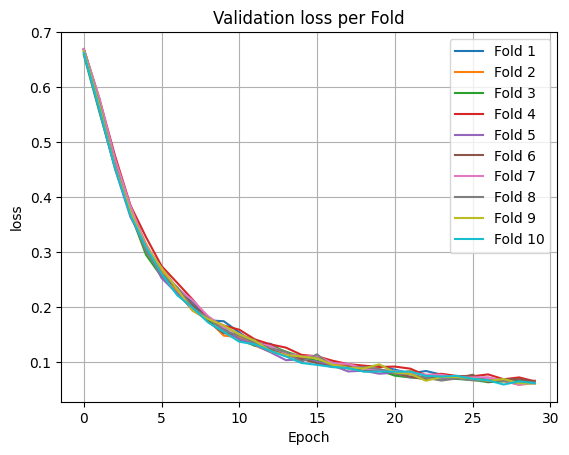

In [23]:
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=f'Fold {i+1}')

plt.title('Validation loss per Fold')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

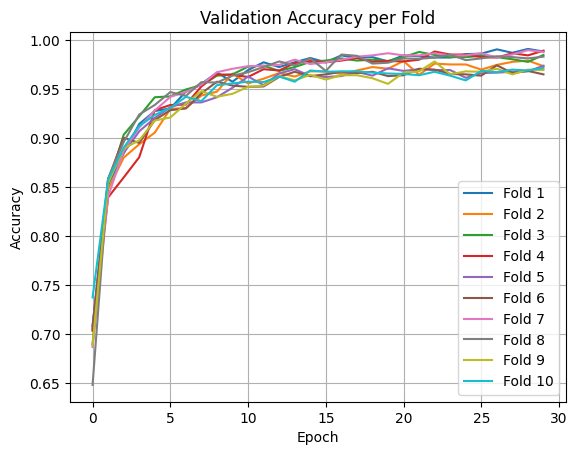

In [24]:
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=f'Fold {i+1}')

plt.title('Validation Accuracy per Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
model.save("../Models/Fake_news_detect_v6.keras")